In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## This Notebook follows closely: 

https://lirnli.wordpress.com/2017/09/17/gaussian-mixture-generative-model/

In [2]:
import torch
from torch import nn

In [227]:
## Random sample of points scattered within a disc segment

def generate_samples(n):
    r = 1+torch.rand(n,1)*0.25
    theta = 2*3.1415926*torch.rand(n,1)
    x = torch.cos(theta)*r
    y = torch.sin(theta)*r
    return x, y


In [228]:
x,y = generate_samples(1000)
print (x.shape)
print (y.shape)

torch.Size([1000, 1])
torch.Size([1000, 1])


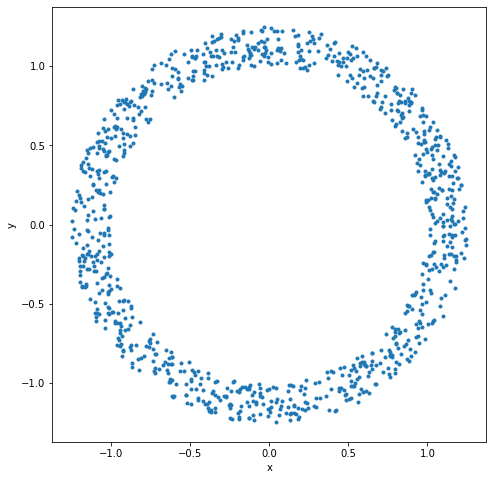

In [229]:
fig = figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

ax.plot(x,y,'.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')

In [230]:
class GaussianMixture(nn.Module):
    def __init__(self,nfeatures = 24, nmix=24):
        super(GaussianMixture, self).__init__()
        
        
        self.nmix = nmix
        
        # Standard Gaussian Mixture model, predict mu, sigma, and pi (membership probability)
#         self.mu = nn.Linear(in_features=1,out_features=nmix)
#         self.log_sigma = nn.Linear(in_features=1,out_features=nmix)
#         self.pi = nn.Linear(in_features=1,out_features=nmix)

  
        # Mixture density network 
        self.mu = nn.Sequential(nn.Linear(1,nfeatures),nn.ReLU(),nn.Linear(nfeatures,nmix)) #nn.Linear(in_features=1,out_features=nmix)
        self.log_sigma = nn.Sequential(nn.Linear(1,nfeatures),nn.ReLU(),nn.Linear(nfeatures,nmix)) #nn.Linear(in_features=1,out_features=nmix)
        self.pi = nn.Sequential(nn.Linear(1,nfeatures),nn.ReLU(),nn.Linear(nfeatures,nmix)) #nn.Linear(in_features=1,out_features=nmix)
        
        
            
        
        #self.main = nn.Sequential(nn.Linear(1,nfeatures),nn.ReLU(),nn.Linear(nfeatures,nmix*3))

        
        self.logsoftmax = nn.LogSoftmax(dim=1) #for log(pi) 

        
    def forward(self, input):
        
        pi = self.pi(input)
        mu = self.mu(input)
        log_sigma = self.log_sigma(input)
    
        #output = self.main(input)
        #mu, log_sigma, pi = output[:,:self.nmix], output[:,self.nmix:self.nmix*2], output[:,self.nmix*2:]

        return pi, mu, log_sigma
    
    def logsumexp(self,x):
        x_max, _ = x.max(dim=1,keepdim=True)
        x_max_expand = x_max.expand(x.size())
        res =  x_max + torch.log((x-x_max_expand).exp().sum(dim=1, keepdim=True))
        return res

    
    
    def logits(self, x, y):
        pi, mu, log_sigma = self.forward(x)
        y_expand = y.expand(mu.size())
        log_pi = self.logsoftmax(pi)
        log_pdf = -0.5*math.log(math.pi*2) - log_sigma - 0.5*((y_expand-mu)/2/log_sigma.exp())**2
        logits = self.logsumexp(log_pi + log_pdf)
        
        return logits
    
    def generate(self, x):
        pi, mu, log_sigma  = self.forward(x)
        #print (pi.shape, mu.shape, log_sigma.shape)
        pi = torch.softmax(pi,dim=1)
        sigma = log_sigma.exp()

        # ************ WORKING **************************
        # For each 
        pi_picked = torch.multinomial(pi,num_samples=1) # sample with probability pi one gaussian member1
        
        m = torch.distributions.categorical.Categorical(probs=pi)
        pi_picked = m.sample()
        
        sigma = log_sigma.exp()
        #print (pi_picked.shape,pi.shape)
        res = torch.zeros(pi.shape[0])
        
        for batch_idx, r in enumerate(pi_picked):
            #print (i)
            res[batch_idx] = torch.normal(mu[batch_idx][r], sigma[batch_idx][r])
        return res
        
        #res = pi*torch.normal(mu, sigma)
            
        #return res.sum(-1)

In [8]:
# Define structure and optimizer

In [278]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net = GaussianMixture(nfeatures=128,nmix=48).to(device)
loss_save = []
batch_size = 256
max_epoch = 1000
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
loss_min = 10.0

# Now let's traing the network

In [283]:
net.train()
for epoch in range(max_epoch):
    optimizer.zero_grad()
    x, y = generate_samples(batch_size)
    x = x.to(device)
    y = y.to(device)
    loss = - net.logits(x,y).mean()
    loss.backward()
    optimizer.step()
    
    loss_scalar = loss.item()
    
    if loss_min >= loss_scalar:
        loss_min = loss_scalar
        torch.save(net.state_dict(),r'best_model.params')
    
    if epoch%100 == 0:
        print("epoch {}, loss {}".format(epoch, loss.item()))
    loss_save.append(loss.item())



epoch 0, loss -0.71576988697052
epoch 100, loss -0.7389423847198486
epoch 200, loss -0.7745639085769653
epoch 300, loss -0.7562445402145386
epoch 400, loss -0.807094931602478
epoch 500, loss -0.7140151262283325
epoch 600, loss -0.734976589679718
epoch 700, loss -0.768034815788269
epoch 800, loss -0.7713134288787842
epoch 900, loss -0.7304633259773254


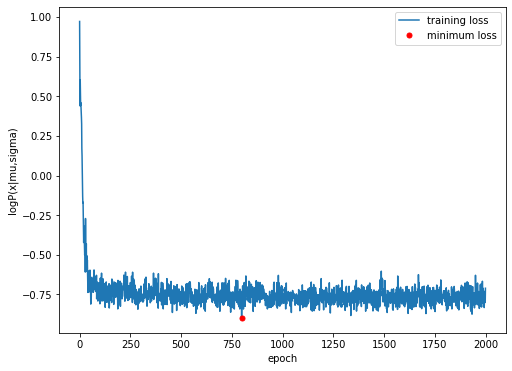

In [284]:
fig = figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(loss_save,label='training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('logP(x|mu,sigma)')
ax.plot(np.argmin(loss_save),loss_min,'ro',ms=5,label='minimum loss')
legend()

# Visualize some samples

In [285]:
net.load_state_dict(torch.load('best_model.params'))
net.eval() ;

Text(0, 0.5, 'y')

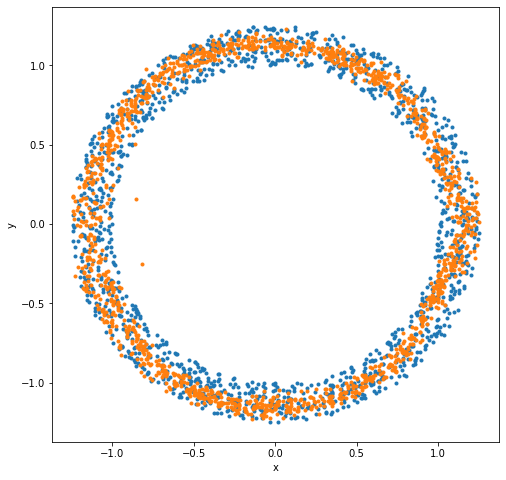

In [286]:
x,y = generate_samples(1500)
xsample = x.to(device)
ysim = net.generate(xsample).detach().numpy()
fig = figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

ax.plot(x,y,'.')
ax.plot(x.squeeze(),ysim,'.')
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_aspect('equal')

In [155]:
tpi = torch.rand(5,24)
m = torch.distributions.categorical.Categorical(probs=tpi)

In [160]:
m.sample()

tensor([12, 22, 10,  2,  4])

In [ ]:
torch.multi